In [1]:
!pip install FDApy

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 93.0/93.0 kB 3.4 MB/s eta 0:00:00


In [2]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score
from tensorflow.keras.datasets import mnist
from FDApy.representation.functional_data import DenseFunctionalData, DenseArgvals, DenseValues
from FDApy.preprocessing import UFPCA
from FDApy.visualization import plot

# Введение

В данном ноутбуке мной было выполнено исследование датасета MNIST с точки зрения преобразования FPCA от его данных. Была выбрана библиотека FDApy, как и для задачи с определением степени полинома, в силу своей удобности.

Провести исследование задачи с адаптивным выбором числа компонент по объяснённой дисперсии было затруднительно, т.к. библиотека не укладывалась в объёмы ОЗУ при объяснённой дисперсии больше 85%. Вероятно, там отбиралось слишком много компонент.

Структура ноутбука:

<ol>
  <li>Число компонент равное 3
  </li>
  <li>Число компонент равное 10
  </li>
  <li>Число компонент равное 30
  </li>
  <li>Адаптивное число компонент
  </li>
  <li>Выводы</li>
</ol>

Ниже выполняется загрузка MNIST датасет из Keras, его нормализация и вытягивание в вектор для дальнейшей обработки

In [3]:
# Загружаем MNIST датасет
(X_train, y_train), (X_test, y_test) = mnist.load_data()

# Нормализуем изображение (шкалируем значения пикселей в [0, 1])
X_train = X_train / 255.0
X_test = X_test / 255.0

# Вытягиваем изображения 28x28 в одномерный вектор
X_train = X_train.reshape(X_train.shape[0], -1)
X_test = X_test.reshape(X_test.shape[0], -1)

11490434/11490434 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step


In [4]:
# Определяем точки сетки (argvals)
argvals = DenseArgvals({'input_dim_0': np.linspace(0, 1, X_train.shape[1])})

# Переводим изображения в DenseFunctionalData
fdata_train = DenseFunctionalData(argvals, DenseValues(X_train))
fdata_test = DenseFunctionalData(argvals, DenseValues(X_test))

# Число компонент равное 3

Здесь датасет переводится в формат библиотеки FDApy. Для этого надо задать плотную сетку (т.к. цифры не в разряженной форме), передать значения в конструктор DenseFunctionalData и применить само преобразование FPCA.

Ниже задаётся число компонент равное 3, на котором далее будет выполнена классификация.

In [5]:
# Выполняем FPCA
fpca = UFPCA(n_components=3)
fpca.fit(fdata_train)

# Трансформируем данные, используя FPCA
X_train_fpca = fpca.transform(fdata_train)
X_test_fpca = fpca.transform(fdata_test)

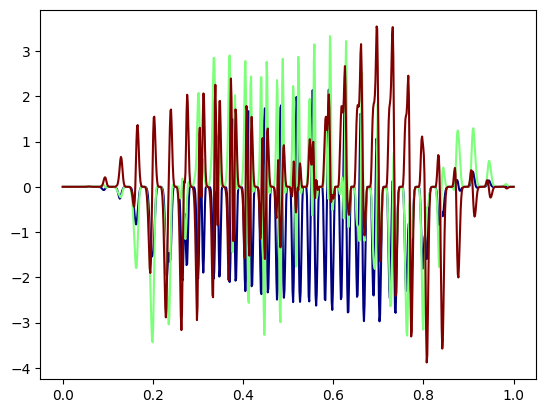

In [6]:
# Визуализируем собственные функции. Они не очень информативны,
# тем не менее посмотреть на них можно
_ = plot(fpca.eigenfunctions)
plt.show()

(-0.5, 27.5, 27.5, -0.5)

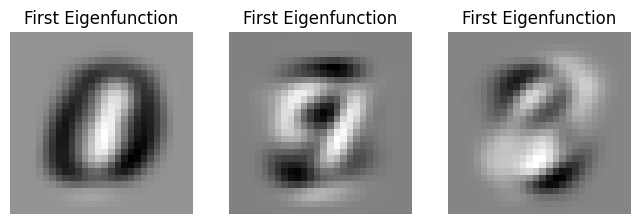

In [7]:
# Выводим отдельно первые 3 собственные функции, чтобы 
# иметь более наглядное представление 
fig, axes = plt.subplots(1, 3, figsize=(8, 3))
axes[0].imshow(fpca.eigenfunctions[0].to_long().values[:, 2].reshape(28, 28), cmap='gray')
axes[0].set_title("First Eigenfunction")
axes[0].axis("off")

axes[1].imshow(fpca.eigenfunctions[1].to_long().values[:, 2].reshape(28, 28), cmap='gray')
axes[1].set_title("First Eigenfunction")
axes[1].axis("off")

axes[2].imshow(fpca.eigenfunctions[2].to_long().values[:, 2].reshape(28, 28), cmap='gray')
axes[2].set_title("First Eigenfunction")
axes[2].axis("off")

(-0.5, 27.5, 27.5, -0.5)

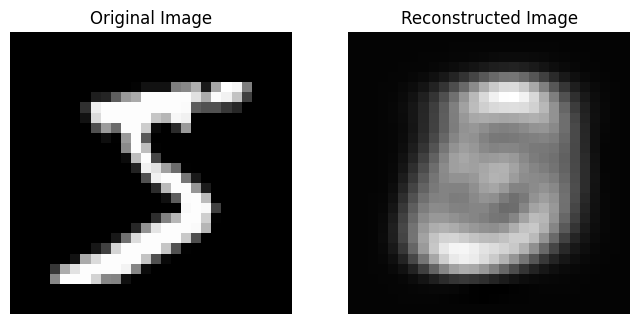

In [8]:
# Восстанавливаем из FPCA данные и выводим сравнительно 
# оригинальное изображение из MNIST и восстановленное 
X_train_reconstruct = fpca.inverse_transform(X_train_fpca)

fig, axes = plt.subplots(1, 2, figsize=(8, 4))
axes[0].imshow(X_train[0].reshape(28, 28), cmap='gray')
axes[0].set_title("Original Image")
axes[0].axis("off")
    
axes[1].imshow(X_train_reconstruct[0].to_long().values[:, 2].reshape(28, 28), cmap='gray')
axes[1].set_title("Reconstructed Image")
axes[1].axis("off")

## Наблюдения

Ожидаемо, три функциональные компоненты не приводят к хорошей классификации. Тем не менее, было интересно узнать какой именно accuracy получится, если настолько сильно обрезать информацию в данных.

In [9]:
# Выполняем классификацию с классическим SVM
clf = SVC(kernel='linear')
clf.fit(X_train_fpca, y_train)
y_pred = clf.predict(X_test_fpca)

# Оценивем accuracy на тесте
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy классификации с использованием FPCA: {accuracy:.4f}")

Accuracy классификации с использованием FPCA: 0.4870


# Число компонент равное 10

В данном случае задаётся число компонент равное 10, на котором далее будет выполнена классификация.

In [10]:
# Выполняем FPCA
fpca = UFPCA(n_components=10)
fpca.fit(fdata_train)

# Трансформируем данные, используя FPCA
X_train_fpca = fpca.transform(fdata_train)
X_test_fpca = fpca.transform(fdata_test)

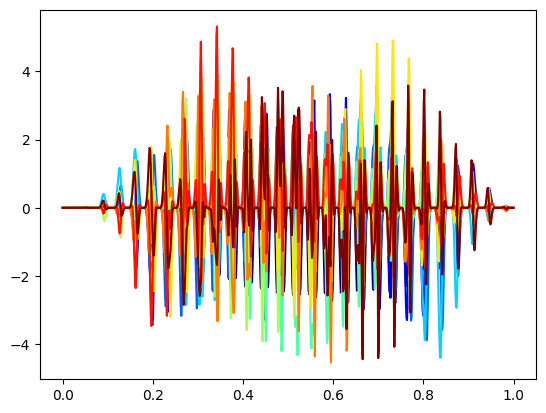

In [11]:
# Визуализируем собственные функции. Они не очень информативны,
# тем не менее посмотреть на них можно
_ = plot(fpca.eigenfunctions)
plt.show()

(-0.5, 27.5, 27.5, -0.5)

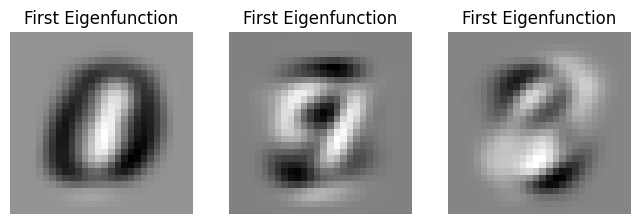

In [12]:
# Выводим отдельно первые 3 собственные функции, чтобы 
# иметь более наглядное представление 
fig, axes = plt.subplots(1, 3, figsize=(8, 3))
axes[0].imshow(fpca.eigenfunctions[0].to_long().values[:, 2].reshape(28, 28), cmap='gray')
axes[0].set_title("First Eigenfunction")
axes[0].axis("off")

axes[1].imshow(fpca.eigenfunctions[1].to_long().values[:, 2].reshape(28, 28), cmap='gray')
axes[1].set_title("First Eigenfunction")
axes[1].axis("off")

axes[2].imshow(fpca.eigenfunctions[2].to_long().values[:, 2].reshape(28, 28), cmap='gray')
axes[2].set_title("First Eigenfunction")
axes[2].axis("off")

(-0.5, 27.5, 27.5, -0.5)

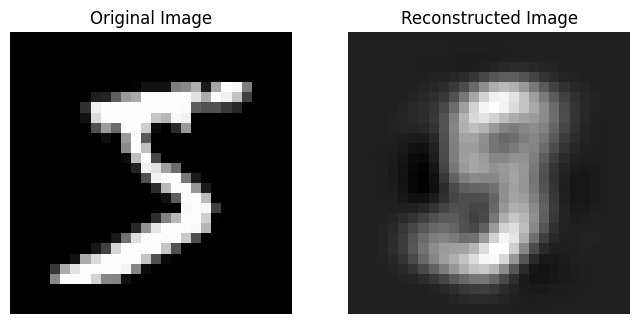

In [13]:
# Восстанавливаем из FPCA данные и выводим сравнительно 
# оригинальное изображение из MNIST и восстановленное 
X_train_reconstruct = fpca.inverse_transform(X_train_fpca)

fig, axes = plt.subplots(1, 2, figsize=(8, 4))
axes[0].imshow(X_train[0].reshape(28, 28), cmap='gray')
axes[0].set_title("Original Image")
axes[0].axis("off")
    
axes[1].imshow(X_train_reconstruct[0].to_long().values[:, 2].reshape(28, 28), cmap='gray')
axes[1].set_title("Reconstructed Image")
axes[1].axis("off")

## Наблюдения

Рост числа компонент с 3 до 10, ожидаемо, приводит к сильному росту качества предсказаний: $ 0.8407 - 0.4870 = 0.3537. $ Неудивительно, что изображения цифр не описываются тремя компонентами, однако, довольно неожиданно, что 10 функциональных компонент уже приводят к неплохому качестве у классификатора - accuracy 0.84 это довольно неплохо.

In [14]:
# Выполняем классификацию с классическим SVM
clf = SVC(kernel='linear')
clf.fit(X_train_fpca, y_train)
y_pred = clf.predict(X_test_fpca)

# Оценивем accuracy на тесте
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy классификации с использованием FPCA: {accuracy:.4f}")

Accuracy классификации с использованием FPCA: 0.8407


# Число компонент равное 30

В данном случае задаётся число компонент равное 30, на котором далее будет выполнена классификация.

In [15]:
# Выполняем FPCA
fpca = UFPCA(n_components=30)
fpca.fit(fdata_train)

# Трансформируем данные, используя FPCA
X_train_fpca = fpca.transform(fdata_train)
X_test_fpca = fpca.transform(fdata_test)

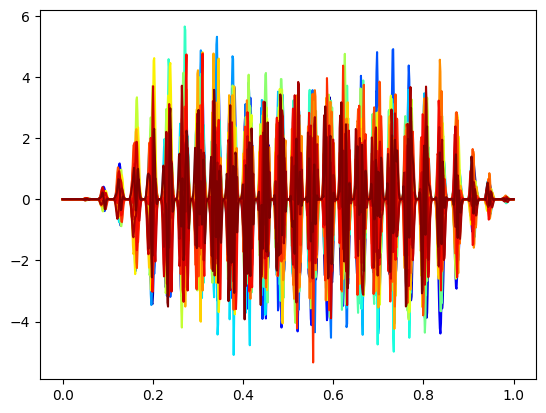

In [16]:
# Визуализируем собственные функции. Они не очень информативны,
# тем не менее посмотреть на них можно
_ = plot(fpca.eigenfunctions)
plt.show()

(-0.5, 27.5, 27.5, -0.5)

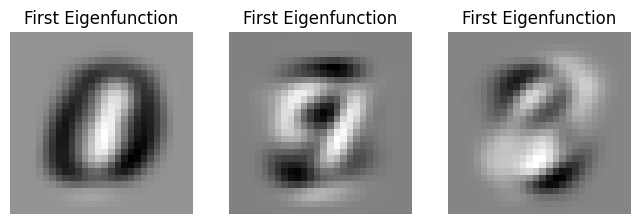

In [17]:
# Выводим отдельно первые 3 собственные функции, чтобы 
# иметь более наглядное представление 
fig, axes = plt.subplots(1, 3, figsize=(8, 3))
axes[0].imshow(fpca.eigenfunctions[0].to_long().values[:, 2].reshape(28, 28), cmap='gray')
axes[0].set_title("First Eigenfunction")
axes[0].axis("off")

axes[1].imshow(fpca.eigenfunctions[1].to_long().values[:, 2].reshape(28, 28), cmap='gray')
axes[1].set_title("First Eigenfunction")
axes[1].axis("off")

axes[2].imshow(fpca.eigenfunctions[2].to_long().values[:, 2].reshape(28, 28), cmap='gray')
axes[2].set_title("First Eigenfunction")
axes[2].axis("off")

(-0.5, 27.5, 27.5, -0.5)

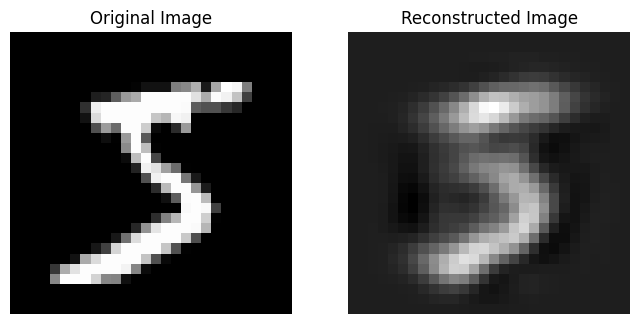

In [18]:
# Восстанавливаем из FPCA данные и выводим сравнительно 
# оригинальное изображение из MNIST и восстановленное 
X_train_reconstruct = fpca.inverse_transform(X_train_fpca)

fig, axes = plt.subplots(1, 2, figsize=(8, 4))
axes[0].imshow(X_train[0].reshape(28, 28), cmap='gray')
axes[0].set_title("Original Image")
axes[0].axis("off")
    
axes[1].imshow(X_train_reconstruct[0].to_long().values[:, 2].reshape(28, 28), cmap='gray')
axes[1].set_title("Reconstructed Image")
axes[1].axis("off")

## Наблюдения

Увеличение accuracy при росте числа компонент с 10 до практически 30 всё ещё заметное: $ 0.9142 - 0.8407 = 0.0735. $ Следует предположить, что реальное число функциональных компонент, описывающих данные, больше 10, т.к. скорость роста accuracy вполне удовлетворительная.

In [19]:
# Выполняем классификацию с классическим SVM
clf = SVC(kernel='linear')
clf.fit(X_train_fpca, y_train)
y_pred = clf.predict(X_test_fpca)

# Оценивем accuracy на тесте
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy классификации с использованием FPCA: {accuracy:.4f}")

Accuracy классификации с использованием FPCA: 0.9142


# Адаптивное число компонент

In [20]:
# Выполняем FPCA так, чтобы разложение
# объясняло 85% дисперсии в данных
fpca = UFPCA(n_components=0.85)
fpca.fit(fdata_train)

# Трансформируем данные, используя FPCA
X_train_fpca = fpca.transform(fdata_train)
X_test_fpca = fpca.transform(fdata_test)

Легко заметить, что число компонент значительно выше, чем в предыдущем примере. Это число собственных функций объясняет 85% дисперсии в данных трэйна

In [21]:
fpca.eigenfunctions

Functional data object with 59 observations on a 1-dimensional support.

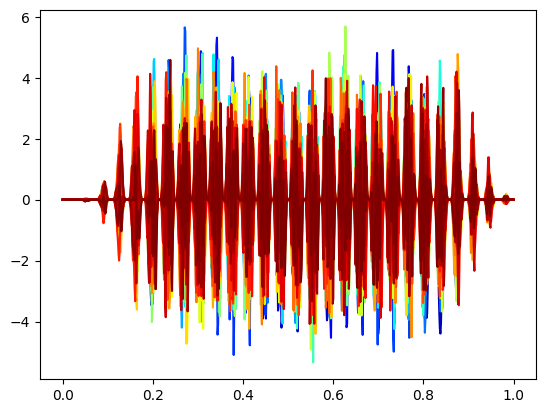

In [22]:
# Визуализируем собственные функции. Они не очень информативны,
# тем не менее посмотреть на них можно
_ = plot(fpca.eigenfunctions)
plt.show()

(-0.5, 27.5, 27.5, -0.5)

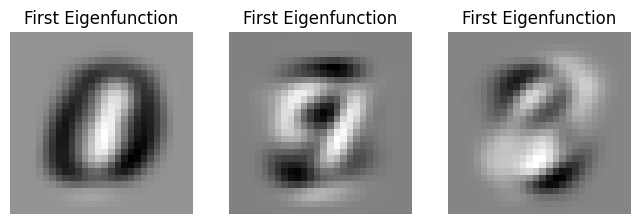

In [23]:
# Выводим отдельно первые 3 собственные функции, чтобы 
# иметь более наглядное представление 
fig, axes = plt.subplots(1, 3, figsize=(8, 3))
axes[0].imshow(fpca.eigenfunctions[0].to_long().values[:, 2].reshape(28, 28), cmap='gray')
axes[0].set_title("First Eigenfunction")
axes[0].axis("off")

axes[1].imshow(fpca.eigenfunctions[1].to_long().values[:, 2].reshape(28, 28), cmap='gray')
axes[1].set_title("First Eigenfunction")
axes[1].axis("off")

axes[2].imshow(fpca.eigenfunctions[2].to_long().values[:, 2].reshape(28, 28), cmap='gray')
axes[2].set_title("First Eigenfunction")
axes[2].axis("off")

(-0.5, 27.5, 27.5, -0.5)

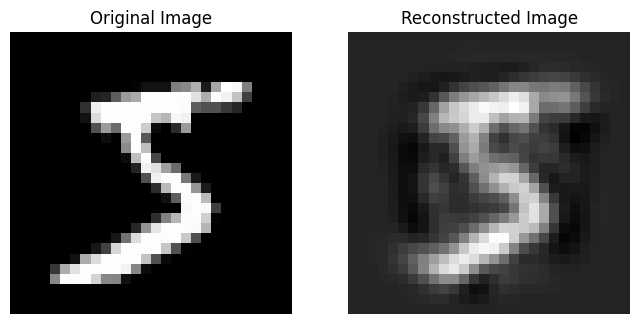

In [24]:
# Восстанавливаем из FPCA данные и выводим сравнительно 
# оригинальное изображение из MNIST и восстановленное 
X_train_reconstruct = fpca.inverse_transform(X_train_fpca)

fig, axes = plt.subplots(1, 2, figsize=(8, 4))
axes[0].imshow(X_train[0].reshape(28, 28), cmap='gray')
axes[0].set_title("Original Image")
axes[0].axis("off")
    
axes[1].imshow(X_train_reconstruct[0].to_long().values[:, 2].reshape(28, 28), cmap='gray')
axes[1].set_title("Reconstructed Image")
axes[1].axis("off")

## Наблюдения

Увеличение accuracy при росте числа компонент с 30 до практически 60 уже незначительно: $ 0.9287 - 0.9142 \approx 0.0145. $ Это указывает на то, что реально число функциональных компонент, нужных для хорошего объяснения данных и классификации лежит в диапазоне 30-40, т.к. дальше рост точности замедляется.

In [25]:
# Выполняем классификацию с классическим SVM
clf = SVC(kernel='linear')
clf.fit(X_train_fpca, y_train)
y_pred = clf.predict(X_test_fpca)

# Оценивем accuracy на тесте
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy классификации с использованием FPCA: {accuracy:.4f}")

Accuracy классификации с использованием FPCA: 0.9287


# График зависимости accuracy от числа компонент 

Accuracy классификации с использованием FPCA: 0.4474
Accuracy классификации с использованием FPCA: 0.4870
Accuracy классификации с использованием FPCA: 0.5949
Accuracy классификации с использованием FPCA: 0.7061
Accuracy классификации с использованием FPCA: 0.7684
Accuracy классификации с использованием FPCA: 0.7943
Accuracy классификации с использованием FPCA: 0.8216
Accuracy классификации с использованием FPCA: 0.8271
Accuracy классификации с использованием FPCA: 0.8407
Accuracy классификации с использованием FPCA: 0.8421
Accuracy классификации с использованием FPCA: 0.8648
Accuracy классификации с использованием FPCA: 0.8760
Accuracy классификации с использованием FPCA: 0.8913
Accuracy классификации с использованием FPCA: 0.9028
Accuracy классификации с использованием FPCA: 0.9118
Accuracy классификации с использованием FPCA: 0.9142


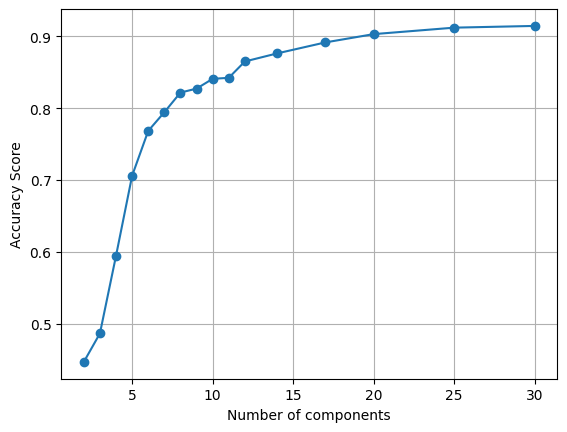

In [26]:
acc_list = []
y_pred_list = []
fpca_list = []
acc_list_x = [2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 14, 17, 20, 25, 30]


for n_components in acc_list_x: 
  # Выполняем FPCA
  fpca = UFPCA(n_components=n_components)
  fpca.fit(fdata_train)

  # Трансформируем данные, используя FPCA
  X_train_fpca = fpca.transform(fdata_train)
  X_test_fpca = fpca.transform(fdata_test)
  # Выполняем классификацию с классическим SVM
  clf = SVC(kernel='linear')
  clf.fit(X_train_fpca, y_train)
  y_pred = clf.predict(X_test_fpca)

  # Оценивем accuracy на тесте
  accuracy = accuracy_score(y_test, y_pred)
  print(f"Accuracy классификации с использованием FPCA: {accuracy:.4f}")
  acc_list.append(accuracy)
  fpca_list.append(fpca)


plt.plot(acc_list_x, acc_list, 'o-')
plt.grid(True)
plt.ylabel('Accuracy Score')
plt.xlabel('Number of components')
plt.show()

# Выводы

1) FPCA позволяет значительно снизить размерность данных, если они представими как функциональные, в задачах с реальными датасетами, такими как MNIST,

2) Тем не менее, задача определения необходимого числа компонент может быть сложной, т.к. алгоритм требователен по памяти и, в данной конкретной ситуации, не мог выполнить разложение, объясняющее > 85% дисперсии в данных.